<a href="https://colab.research.google.com/github/BelloBer/Landslide-Detection/blob/main/complete2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#OPTIMIZED CODE
EXPECTED OUTPUT
* higher f1 score for landslide (above 0.68)
* Balanced F1 scores > 0.9 for both classes
* Faster convergence due to better architecture
* More stable training with residual connections
* Better generalization from improved regularization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Flatten, Conv2D, MaxPooling2D, Dropout,
                                   BatchNormalization, Input, GlobalAveragePooling2D,
                                   SeparableConv2D, Add, Activation)
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import datetime
from collections import Counter
import gc
from scipy import ndimage

# Updated Configuration for 64x64 images
CONFIG = {
    'TRAIN_DATA': '/content/drive/My Drive/train_data/',
    'TEST_DATA': '/content/drive/My Drive/test_data/',
    'TRAIN_CSV': "/content/drive/My Drive/train_data/Train.csv",
    'TEST_CSV': "/content/drive/My Drive/test_data/Test.csv",
    'BATCH_SIZE': 16,
    'IMG_SIZE': 64,  # Changed from 256 to 64
    'CHANNELS': 12,
    'EPOCHS': 100,
    'LEARNING_RATE': 0.0001,
    'PATIENCE': 15,
    'VALIDATION_SPLIT': 0.2
}

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class DataProcessor:
    """Handles data loading and preprocessing with improved normalization"""

    @staticmethod
    def load_and_normalize_image(image_id, folder_path):
        """Enhanced image loading with better SAR processing"""
        try:
            image_path = os.path.join(folder_path, f"{image_id}.npy")
            if not os.path.exists(image_path):
                return None

            img = np.load(image_path)

            if len(img.shape) != 3 or img.shape[2] != 12:
                return None

            # Check actual image size and log it for debugging
            actual_size = img.shape[:2]
            if actual_size != (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']):
                print(f"Warning: Image {image_id} has size {actual_size}, expected {(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])}")
                # Resize if needed
                from tensorflow.keras.preprocessing.image import smart_resize
                img_resized = np.zeros((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], CONFIG['CHANNELS']))
                for ch in range(CONFIG['CHANNELS']):
                    img_resized[:, :, ch] = smart_resize(img[:, :, ch:ch+1], (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])).squeeze()
                img = img_resized

            img_normalized = np.zeros_like(img, dtype=np.float32)

            # Optical bands (0-3) - Enhanced normalization
            for band in range(4):
                band_data = img[:, :, band].astype(np.float32)

                # Remove outliers using percentile clipping
                p2, p98 = np.percentile(band_data, [2, 98])
                band_data = np.clip(band_data, p2, p98)

                # Robust normalization
                if p98 > p2:
                    img_normalized[:, :, band] = (band_data - p2) / (p98 - p2)
                else:
                    img_normalized[:, :, band] = 0.5

            # SAR bands (4-11) - Improved SAR processing
            for band in range(4, 12):
                sar_data = img[:, :, band].astype(np.float32)

                # Convert to dB with proper handling
                sar_positive = np.abs(sar_data)
                sar_positive = np.maximum(sar_positive, 1e-12)
                sar_db = 10 * np.log10(sar_positive + 1e-12)

                # Clip extreme values
                sar_db = np.clip(sar_db, -50, 10)

                # Normalize to [0, 1]
                img_normalized[:, :, band] = (sar_db + 50) / 60

            return img_normalized

        except Exception as e:
            print(f"Error loading {image_id}: {str(e)}")
            return None

class MultiChannelAugmenter:
    """Custom augmentation for multi-channel images (12 channels) optimized for 64x64"""

    def __init__(self, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
                 zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
                 brightness_range=[0.9, 1.1], noise_factor=0.03):
        # Reduced augmentation ranges for smaller 64x64 images
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.brightness_range = brightness_range
        self.noise_factor = noise_factor

    def random_rotation(self, image, angle_range):
        """Apply random rotation to all channels"""
        angle = np.random.uniform(-angle_range, angle_range)
        rotated = np.zeros_like(image)
        for i in range(image.shape[2]):
            rotated[:, :, i] = ndimage.rotate(image[:, :, i], angle, reshape=False, mode='reflect')
        return rotated

    def random_shift(self, image, width_range, height_range):
        """Apply random translation to all channels"""
        h, w = image.shape[:2]
        dx = int(np.random.uniform(-width_range, width_range) * w)
        dy = int(np.random.uniform(-height_range, height_range) * h)

        shifted = np.zeros_like(image)
        for i in range(image.shape[2]):
            shifted[:, :, i] = ndimage.shift(image[:, :, i], [dy, dx], mode='reflect')
        return shifted

    def random_zoom(self, image, zoom_range):
        """Apply random zoom to all channels"""
        zoom_factor = np.random.uniform(1-zoom_range, 1+zoom_range)
        zoomed = np.zeros_like(image)

        for i in range(image.shape[2]):
            zoomed_channel = ndimage.zoom(image[:, :, i], zoom_factor, mode='reflect')

            # Crop or pad to maintain original size
            orig_h, orig_w = image.shape[:2]
            if zoom_factor > 1:  # Crop
                h, w = zoomed_channel.shape
                start_h = max(0, (h - orig_h) // 2)
                start_w = max(0, (w - orig_w) // 2)
                end_h = min(h, start_h + orig_h)
                end_w = min(w, start_w + orig_w)
                cropped = zoomed_channel[start_h:end_h, start_w:end_w]

                # Pad if necessary
                if cropped.shape != (orig_h, orig_w):
                    padded = np.zeros((orig_h, orig_w))
                    h_pad = (orig_h - cropped.shape[0]) // 2
                    w_pad = (orig_w - cropped.shape[1]) // 2
                    padded[h_pad:h_pad+cropped.shape[0], w_pad:w_pad+cropped.shape[1]] = cropped
                    zoomed[:, :, i] = padded
                else:
                    zoomed[:, :, i] = cropped

            elif zoom_factor < 1:  # Pad
                h, w = zoomed_channel.shape
                padded = np.zeros((orig_h, orig_w))
                pad_h = (orig_h - h) // 2
                pad_w = (orig_w - w) // 2
                padded[pad_h:pad_h+h, pad_w:pad_w+w] = zoomed_channel
                zoomed[:, :, i] = padded
            else:
                zoomed[:, :, i] = zoomed_channel

        return zoomed

    def random_flip(self, image):
        """Apply random flips to all channels"""
        flipped = image.copy()

        if self.horizontal_flip and np.random.random() > 0.5:
            flipped = np.fliplr(flipped)

        if self.vertical_flip and np.random.random() > 0.5:
            flipped = np.flipud(flipped)

        return flipped

    def random_brightness(self, image):
        """Apply brightness adjustment only to optical bands (0-3)"""
        augmented = image.copy()

        # Only apply to optical bands (channels 0-3)
        brightness_factor = np.random.uniform(self.brightness_range[0], self.brightness_range[1])
        for i in range(4):  # Only optical bands
            augmented[:, :, i] = np.clip(augmented[:, :, i] * brightness_factor, 0, 1)

        return augmented

    def add_noise(self, image):
        """Add small amount of noise"""
        noise = np.random.normal(0, self.noise_factor, image.shape)
        return np.clip(image + noise, 0, 1)

    def random_transform(self, image):
        """Apply random combination of augmentations"""
        augmented = image.copy()

        # Apply transformations with certain probabilities
        if np.random.random() > 0.5:
            augmented = self.random_rotation(augmented, self.rotation_range)

        if np.random.random() > 0.5:
            augmented = self.random_shift(augmented, self.width_shift_range, self.height_shift_range)

        if np.random.random() > 0.3:
            augmented = self.random_zoom(augmented, self.zoom_range)

        if np.random.random() > 0.5:
            augmented = self.random_flip(augmented)

        if np.random.random() > 0.3:
            augmented = self.random_brightness(augmented)

        if np.random.random() > 0.7:
            augmented = self.add_noise(augmented)

        return augmented

class BalancedDataGenerator(Sequence):
    """Improved data generator with custom multi-channel augmentation"""

    def __init__(self, image_ids, labels, folder_path, batch_size=16,
                 augment=False, shuffle=True, balance_classes=True):
        super().__init__()

        self.image_ids = np.array(image_ids)
        self.labels = np.array(labels)
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.balance_classes = balance_classes

        # Validate files
        self.valid_indices = self._validate_files()
        if len(self.valid_indices) == 0:
            raise FileNotFoundError(f"No valid files found in {folder_path}")

        # Create class-balanced indices if needed
        if self.balance_classes:
            self._create_balanced_indices()
        else:
            self.balanced_indices = self.valid_indices.copy()

        self.on_epoch_end()

        # Use custom multi-channel augmenter
        if self.augment:
            self.augmenter = MultiChannelAugmenter(
                rotation_range=30,
                width_shift_range=0.2,
                height_shift_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                brightness_range=[0.9, 1.1],
                noise_factor=0.02
            )

    def _validate_files(self):
        """Validate file existence and readability"""
        valid_indices = []
        for idx, img_id in enumerate(self.image_ids):
            file_path = os.path.join(self.folder_path, f"{img_id}.npy")
            if os.path.exists(file_path):
                try:
                    test_img = np.load(file_path)
                    if len(test_img.shape) == 3 and test_img.shape[2] == 12:
                        valid_indices.append(idx)
                except:
                    continue
        return np.array(valid_indices)

    def _create_balanced_indices(self):
        """Create balanced sampling indices"""
        # Separate indices by class
        valid_labels = self.labels[self.valid_indices]
        class_0_indices = self.valid_indices[valid_labels == 0]
        class_1_indices = self.valid_indices[valid_labels == 1]

        # Oversample minority class
        min_class_size = min(len(class_0_indices), len(class_1_indices))
        max_class_size = max(len(class_0_indices), len(class_1_indices))

        # Create balanced dataset by oversampling
        if len(class_0_indices) < len(class_1_indices):
            # Oversample class 0
            oversample_indices = np.random.choice(class_0_indices,
                                                len(class_1_indices) - len(class_0_indices))
            class_0_indices = np.concatenate([class_0_indices, oversample_indices])
        else:
            # Oversample class 1
            oversample_indices = np.random.choice(class_1_indices,
                                                len(class_0_indices) - len(class_1_indices))
            class_1_indices = np.concatenate([class_1_indices, oversample_indices])

        self.balanced_indices = np.concatenate([class_0_indices, class_1_indices])
        print(f"Balanced dataset: {len(self.balanced_indices)} samples")

    def __len__(self):
        return int(np.ceil(len(self.balanced_indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.balanced_indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_id = self.image_ids[i]
            label = self.labels[i]

            img = DataProcessor.load_and_normalize_image(img_id, self.folder_path)
            if img is not None:
                if self.augment:
                    img = self.augmenter.random_transform(img)
                batch_images.append(img)
                batch_labels.append(label)

        # Ensure we have a full batch
        while len(batch_images) < len(batch_indices) and len(batch_images) > 0:
            rand_idx = np.random.randint(0, len(batch_images))
            batch_images.append(batch_images[rand_idx])
            batch_labels.append(batch_labels[rand_idx])

        return np.array(batch_images), np.array(batch_labels, dtype=np.float32)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.balanced_indices)

class ModelBuilder:
    """Builds improved CNN architecture optimized for 64x64 images"""

    @staticmethod
    def residual_block(x, filters, kernel_size=3):
        """Residual block for better gradient flow"""
        shortcut = x

        x = SeparableConv2D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = SeparableConv2D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)

        # Adjust shortcut if needed
        if shortcut.shape[-1] != filters:
            shortcut = Conv2D(filters, 1, padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)

        x = Add()([x, shortcut])
        x = Activation('relu')(x)
        return x

    @staticmethod
    def build_improved_model(input_shape):
        """Build improved CNN optimized for 64x64 input"""
        inputs = Input(shape=input_shape)

        # Initial convolution - smaller stride for 64x64 input
        x = Conv2D(32, (5, 5), strides=1, padding='same')(inputs)  # Changed stride from 2 to 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((2, 2))(x)  # 64x64 -> 32x32

        # Residual blocks with appropriate pooling for smaller input
        x = ModelBuilder.residual_block(x, 64)
        x = MaxPooling2D((2, 2))(x)  # 32x32 -> 16x16
        x = Dropout(0.25)(x)

        x = ModelBuilder.residual_block(x, 128)
        x = MaxPooling2D((2, 2))(x)  # 16x16 -> 8x8
        x = Dropout(0.25)(x)

        x = ModelBuilder.residual_block(x, 256)
        x = MaxPooling2D((2, 2))(x)  # 8x8 -> 4x4
        x = Dropout(0.3)(x)

        # Additional residual block since we have fewer pooling layers
        x = ModelBuilder.residual_block(x, 512)
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.5)(x)

        # Classification head - adjusted for smaller feature maps
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs, outputs)
        return model

# Custom metrics
def precision_m(y_true, y_pred):
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    predicted_positives = tf.reduce_sum(y_pred)
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def recall_m(y_true, y_pred):
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    possible_positives = tf.reduce_sum(y_true)
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# Improved focal loss
def focal_loss(alpha=0.7, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

        # Calculate focal loss
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        focal_weight = y_true * (1 - y_pred) ** gamma + (1 - y_true) * y_pred ** gamma

        # Binary crossentropy
        bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

        return tf.reduce_mean(alpha_factor * focal_weight * bce)

    return focal_loss_fixed

# Main execution
def main():
    print("Starting optimized landslide detection training...")

    # Load data
    train_df = pd.read_csv(CONFIG['TRAIN_CSV'])
    print(f"Loaded {len(train_df)} training samples")
    print(f"Class distribution: {train_df['label'].value_counts().to_dict()}")

    # Check actual image sizes
    print("Checking image sizes...")
    sample_ids = train_df['ID'].values[:5]  # Check first 5 images
    for img_id in sample_ids:
        img_path = os.path.join(CONFIG['TRAIN_DATA'], f"{img_id}.npy")
        if os.path.exists(img_path):
            img = np.load(img_path)
            print(f"Image {img_id}: shape {img.shape}")
        else:
            print(f"Image {img_id}: not found")

    # Stratified split
    train_idx, val_idx = train_test_split(
        np.arange(len(train_df)),
        test_size=CONFIG['VALIDATION_SPLIT'],
        random_state=42,
        stratify=train_df['label']
    )

    # Create generators
    train_gen = BalancedDataGenerator(
        image_ids=train_df['ID'].values[train_idx],
        labels=train_df['label'].values[train_idx],
        folder_path=CONFIG['TRAIN_DATA'],
        batch_size=CONFIG['BATCH_SIZE'],
        augment=True,
        balance_classes=True
    )

    val_gen = BalancedDataGenerator(
        image_ids=train_df['ID'].values[val_idx],
        labels=train_df['label'].values[val_idx],
        folder_path=CONFIG['TRAIN_DATA'],
        batch_size=CONFIG['BATCH_SIZE'],
        augment=False,
        balance_classes=False
    )

    print(f"Training batches: {len(train_gen)}")
    print(f"Validation batches: {len(val_gen)}")

    # Build model with correct input shape
    input_shape = (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], CONFIG['CHANNELS'])
    print(f"Building model with input shape: {input_shape}")
    model = ModelBuilder.build_improved_model(input_shape)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE']),
        loss=focal_loss(alpha=0.7, gamma=2.0),
        metrics=['accuracy', precision_m, recall_m, f1_m]
    )

    print("Model compiled successfully")
    model.summary()

    # Callbacks
    callbacks = [
        ModelCheckpoint(
            'best_landslide_model.keras',
            monitor='val_f1_m',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_f1_m',
            mode='max',
            patience=CONFIG['PATIENCE'],
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-7,
            verbose=1
        )
    ]

    # Calculate class weights
    y_train = train_df['label'].values[train_idx]
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    print(f"Class weights: {class_weight_dict}")

    # Train model
    print("Starting training...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=CONFIG['EPOCHS'],
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )

    # Load best model
    model.load_weights('best_landslide_model.keras')

    # Threshold optimization
    print("\nOptimizing classification threshold...")
    val_predictions = []
    val_labels = []

    for i in range(len(val_gen)):
        batch_x, batch_y = val_gen[i]
        pred_batch = model.predict(batch_x, verbose=0)
        val_predictions.extend(pred_batch.flatten())
        val_labels.extend(batch_y.flatten())

    # Additional debugging for threshold optimization
    print(f"Prediction probability range: {y_probs.min():.4f} to {y_probs.max():.4f}")
    print(f"Prediction probability mean: {y_probs.mean():.4f}")
    print(f"True label distribution: {np.bincount(y_true.astype(int))}")

    # If no good threshold found, use default evaluation
    if not best_metrics:
        print("Warning: No optimal threshold found, using default 0.5")
        best_thresh = 0.5
        y_pred_default = (y_probs > 0.5).astype(int)
        if len(np.unique(y_pred_default)) > 1:
            f1_default = f1_score(y_true, y_pred_default, average='weighted', zero_division=0)
            best_metrics = {
                'threshold': 0.5,
                'weighted_f1': f1_default,
                'class_0_f1': 0.0,
                'class_1_f1': 0.0
            }
        else:
            best_metrics = {
                'threshold': 0.5,
                'weighted_f1': 0.0,
                'class_0_f1': 0.0,
                'class_1_f1': 0.0
            }

    # Find optimal threshold using F1 score
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1 = 0
    best_thresh = 0.5
    best_metrics = {}

    for thresh in thresholds:
        y_pred = (y_probs > thresh).astype(int)

        # Skip thresholds that result in all one class
        if len(np.unique(y_pred)) < 2:
            continue

        try:
            f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

                # Calculate per-class F1 scores safely
                report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
                best_metrics = {
                    'threshold': thresh,
                    'weighted_f1': f1,
                    'class_0_f1': report.get('0', {}).get('f1-score', 0.0),
                    'class_1_f1': report.get('1', {}).get('f1-score', 0.0)
                }
        except Exception as e:
            print(f"Error at threshold {thresh}: {e}")
            continue

    print(f"\nBest threshold: {best_thresh:.3f}")
    print(f"Weighted F1: {best_metrics.get('weighted_f1', 0.0):.4f}")
    print(f"Class 0 F1: {best_metrics.get('class_0_f1', 0.0):.4f}")
    print(f"Class 1 F1: {best_metrics.get('class_1_f1', 0.0):.4f}")

    # Final evaluation
    y_pred_final = (y_probs > best_thresh).astype(int)
    print(f"\nFinal Classification Report:")
    print(classification_report(y_true, y_pred_final, target_names=['No Landslide', 'Landslide'], zero_division=0))

    # Plot training history
    plot_training_history(history)

    # Generate test predictions
    generate_test_predictions(model, best_thresh)

    print("Training completed successfully!")
    return model, best_thresh

def plot_training_history(history):
    """Plot training metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    metrics = ['accuracy', 'loss', 'f1_m', 'precision_m']
    titles = ['Accuracy', 'Loss', 'F1 Score', 'Precision']

    for i, (metric, title) in enumerate(zip(metrics, titles)):
        row, col = i // 2, i % 2

        if metric in history.history:
            axes[row, col].plot(history.history[metric], label=f'Training {title}')
            if f'val_{metric}' in history.history:
                axes[row, col].plot(history.history[f'val_{metric}'], label=f'Validation {title}')

            axes[row, col].set_title(title)
            axes[row, col].set_xlabel('Epoch')
            axes[row, col].set_ylabel(title)
            axes[row, col].legend()

    plt.tight_layout()
    plt.show()

def generate_test_predictions(model, threshold):
    """Generate test predictions"""
    test_df = pd.read_csv(CONFIG['TEST_CSV'])
    test_ids = test_df['ID'].values

    predictions = []
    batch_size = CONFIG['BATCH_SIZE']

    print(f"Generating predictions for {len(test_ids)} test images...")

    for i in range(0, len(test_ids), batch_size):
        batch_ids = test_ids[i:i+batch_size]
        batch_imgs = []

        for img_id in batch_ids:
            img = DataProcessor.load_and_normalize_image(img_id, CONFIG['TEST_DATA'])
            if img is not None:
                batch_imgs.append(img)
            else:
                batch_imgs.append(np.zeros((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], CONFIG['CHANNELS'])))

        batch_imgs = np.array(batch_imgs)
        probs = model.predict(batch_imgs, verbose=0).flatten()
        preds = (probs > threshold).astype(int)
        predictions.extend(preds)

        if (i // batch_size + 1) % 10 == 0:
            print(f"Processed {min(i+batch_size, len(test_ids))}/{len(test_ids)}")

    # Create submission
    submission_df = pd.DataFrame({
        'ID': test_ids,
        'label': np.array(predictions, dtype=int)
    })

    submission_df.to_csv('optimized_submission.csv', index=False)
    print(f"Submission saved. Prediction distribution: {Counter(predictions)}")

if __name__ == "__main__":
    # Clear memory
    tf.keras.backend.clear_session()
    gc.collect()

    # Run main training
    model, best_threshold = main()

Mounted at /content/drive
Starting optimized landslide detection training...
Loaded 7147 training samples
Class distribution: {0: 5892, 1: 1255}
Checking image sizes...
Image ID_HUD1ST: shape (64, 64, 12)
Image ID_KGE2HY: shape (64, 64, 12)
Image ID_VHV9BL: shape (64, 64, 12)
Image ID_ZT0VEJ: shape (64, 64, 12)
Image ID_5NFXVY: shape (64, 64, 12)
Balanced dataset: 9426 samples
Training batches: 590
Validation batches: 90
Building model with input shape: (64, 64, 12)
Model compiled successfully


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      9,632 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 32, 32,    │      2,400 │ max_pooling2d[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 32, 32,    │      4,736 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 16, 16,    │      8,896 │ dropout[0][0]   

 Total params: 899,329 (3.43 MB)

 Trainable params: 892,737 (3.41 MB)

 Non-trainable params: 6,592 (25.75 KB)

Class weights: {0: np.float64(0.6065138977296839), 1: np.float64(2.8471115537848606)}
Starting training...
Epoch 1/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.5482 - f1_m: 7.9671 - loss: 0.4236 - precision_m: 7.9698 - recall_m: 8.3835
Epoch 1: val_f1_m improved from -inf to 4.26470, saving model to best_landslide_model.keras
590/590 ━━━━━━━━━━━━━━━━━━━━ 225s 339ms/step - accuracy: 0.5483 - f1_m: 7.9676 - loss: 0.4235 - precision_m: 7.9698 - recall_m: 8.3844 - val_accuracy: 0.4629 - val_f1_m: 4.2647 - val_loss: 0.0608 - val_precision_m: 2.7889 - val_recall_m: 10.5889 - learning_rate: 1.0000e-04
Epoch 2/100
590/590 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.6382 - f1_m: 8.7426 - loss: 0.2578 - precision_m: 8.0198 - recall_m: 10.0053
Epoch 2: val_f1_m did not improve from 4.26470
590/590 ━━━━━━━━━━━━━━━━━━━━ 183s 310ms/step - accuracy: 0.6382 - f1_m: 8.7427 - loss: 0.2578 - precision_m: 8.0197 - recall_m: 10.0056 - val_accuracy: 0.5727 - val_f1_m: 4.1121 - val_loss:

NameError: name 'y_probs' is not defined

Configuring GPU...
Found 1 GPU(s)
GPU configuration warning: Physical devices cannot be modified after being initialized
Continuing with default GPU settings...
Mixed precision policy: mixed_float16
=== GPU Status ===
GPUtil not available. Install with: pip install GPUtil

TensorFlow GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available and configured for TensorFlow
Starting optimized landslide detection training...
Using device: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loaded 7147 training samples
Class distribution: {0: 5892, 1: 1255}
Checking image sizes...
Image ID_HUD1ST: shape (64, 64, 12)
Image ID_KGE2HY: shape (64, 64, 12)
Image ID_VHV9BL: shape (64, 64, 12)
Image ID_ZT0VEJ: shape (64, 64, 12)
Image ID_5NFXVY: shape (64, 64, 12)
Balanced dataset: 9426 samples
Training batches: 295
Validation batches: 45
Building model with input shape: (64, 64, 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      9,632 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 32, 32,    │      2,400 │ max_pooling2d[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 32, 32,    │      4,736 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 16, 16,    │      8,896 │ dropout[0][0]   

 Total params: 899,329 (3.43 MB)

 Trainable params: 892,737 (3.41 MB)

 Non-trainable params: 6,592 (25.75 KB)

Class weights: {0: np.float64(0.6065138977296839), 1: np.float64(2.8471115537848606)}
Starting training...
Epoch 1/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.5516 - f1_m: 16.2053 - loss: 0.4137 - precision_m: 15.9815 - recall_m: 16.8304
Epoch 1: val_f1_m improved from -inf to 0.00000, saving model to best_landslide_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 230s 694ms/step - accuracy: 0.5517 - f1_m: 16.2064 - loss: 0.4135 - precision_m: 15.9815 - recall_m: 16.8330 - val_accuracy: 0.8245 - val_f1_m: 0.0000e+00 - val_loss: 0.0587 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.6280 - f1_m: 17.4543 - loss: 0.2429 - precision_m: 15.8028 - recall_m: 19.8934
Epoch 2: val_f1_m improved from 0.00000 to 9.05741, saving model to best_landslide_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 191s 647ms/step - accuracy: 0.6280 - f1_m: 17.4550 - loss: 0.2428 - precision_m: 15.8034 - re

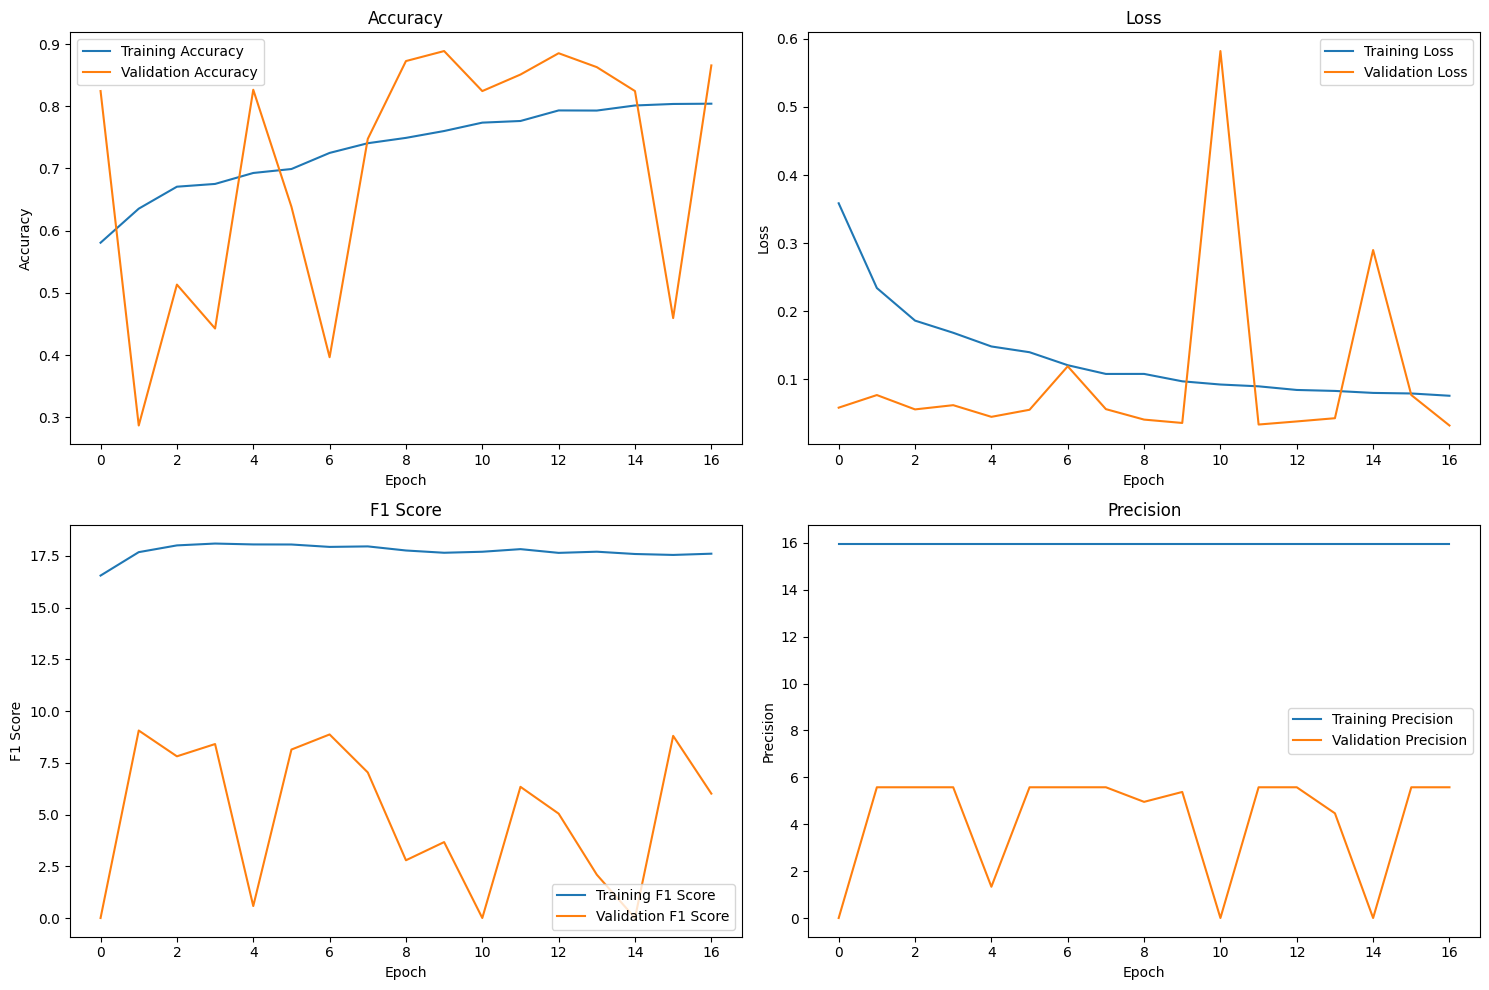

Generating predictions for 5398 test images...
Processed 320/5398
Processed 640/5398
Processed 960/5398
Processed 1280/5398
Processed 1600/5398
Processed 1920/5398
Processed 2240/5398
Processed 2560/5398
Processed 2880/5398
Processed 3200/5398
Processed 3520/5398
Processed 3840/5398
Processed 4160/5398
Processed 4480/5398
Processed 4800/5398
Processed 5120/5398
Submission saved. Prediction distribution: Counter({np.int64(0): 5318, np.int64(1): 80})
Training completed successfully!


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import datetime
from collections import Counter
import gc
from scipy import ndimage

# Configure GPU BEFORE importing TensorFlow
import tensorflow as tf

# Configure GPU usage - must be done before any TF operations
print("Configuring GPU...")
try:
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        print(f"Found {len(physical_devices)} GPU(s)")
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    else:
        print("No GPU found, using CPU")
except RuntimeError as e:
    print(f"GPU configuration warning: {e}")
    print("Continuing with default GPU settings...")

# Import TensorFlow components after GPU configuration
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Flatten, Conv2D, MaxPooling2D, Dropout,
                                   BatchNormalization, Input, GlobalAveragePooling2D,
                                   SeparableConv2D, Add, Activation)
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

# Mixed precision for better GPU performance
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print(f"Mixed precision policy: {policy.name}")
except Exception as e:
    print(f"Mixed precision setup failed: {e}")
    print("Continuing with default precision...")

# Updated Configuration for 64x64 images
CONFIG = {
    'TRAIN_DATA': '/content/drive/My Drive/train_data/',
    'TEST_DATA': '/content/drive/My Drive/test_data/',
    'TRAIN_CSV': "/content/drive/My Drive/train_data/Train.csv",
    'TEST_CSV': "/content/drive/My Drive/test_data/Test.csv",
    'BATCH_SIZE': 32,  # Increased batch size for better GPU utilization
    'IMG_SIZE': 64,
    'CHANNELS': 12,
    'EPOCHS': 100,
    'LEARNING_RATE': 0.0001,
    'PATIENCE': 15,
    'VALIDATION_SPLIT': 0.2
}

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class DataProcessor:
    """Handles data loading and preprocessing with improved normalization"""

    @staticmethod
    def load_and_normalize_image(image_id, folder_path):
        """Enhanced image loading with better SAR processing"""
        try:
            image_path = os.path.join(folder_path, f"{image_id}.npy")
            if not os.path.exists(image_path):
                return None

            img = np.load(image_path)

            if len(img.shape) != 3 or img.shape[2] != 12:
                return None

            # Check actual image size and resize if needed
            actual_size = img.shape[:2]
            if actual_size != (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']):
                from tensorflow.keras.preprocessing.image import smart_resize
                img_resized = np.zeros((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], CONFIG['CHANNELS']))
                for ch in range(CONFIG['CHANNELS']):
                    img_resized[:, :, ch] = smart_resize(img[:, :, ch:ch+1], (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])).squeeze()
                img = img_resized

            img_normalized = np.zeros_like(img, dtype=np.float32)

            # Optical bands (0-3) - Enhanced normalization
            for band in range(4):
                band_data = img[:, :, band].astype(np.float32)

                # Remove outliers using percentile clipping
                p2, p98 = np.percentile(band_data, [2, 98])
                band_data = np.clip(band_data, p2, p98)

                # Robust normalization
                if p98 > p2:
                    img_normalized[:, :, band] = (band_data - p2) / (p98 - p2)
                else:
                    img_normalized[:, :, band] = 0.5

            # SAR bands (4-11) - Improved SAR processing
            for band in range(4, 12):
                sar_data = img[:, :, band].astype(np.float32)

                # Convert to dB with proper handling
                sar_positive = np.abs(sar_data)
                sar_positive = np.maximum(sar_positive, 1e-12)
                sar_db = 10 * np.log10(sar_positive + 1e-12)

                # Clip extreme values
                sar_db = np.clip(sar_db, -50, 10)

                # Normalize to [0, 1]
                img_normalized[:, :, band] = (sar_db + 50) / 60

            return img_normalized

        except Exception as e:
            print(f"Error loading {image_id}: {str(e)}")
            return None

class MultiChannelAugmenter:
    """Custom augmentation for multi-channel images (12 channels) optimized for 64x64"""

    def __init__(self, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
                 zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
                 brightness_range=[0.9, 1.1], noise_factor=0.03):
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.brightness_range = brightness_range
        self.noise_factor = noise_factor

    def random_rotation(self, image, angle_range):
        """Apply random rotation to all channels"""
        angle = np.random.uniform(-angle_range, angle_range)
        rotated = np.zeros_like(image)
        for i in range(image.shape[2]):
            rotated[:, :, i] = ndimage.rotate(image[:, :, i], angle, reshape=False, mode='reflect')
        return rotated

    def random_shift(self, image, width_range, height_range):
        """Apply random translation to all channels"""
        h, w = image.shape[:2]
        dx = int(np.random.uniform(-width_range, width_range) * w)
        dy = int(np.random.uniform(-height_range, height_range) * h)

        shifted = np.zeros_like(image)
        for i in range(image.shape[2]):
            shifted[:, :, i] = ndimage.shift(image[:, :, i], [dy, dx], mode='reflect')
        return shifted

    def random_zoom(self, image, zoom_range):
        """Apply random zoom to all channels"""
        zoom_factor = np.random.uniform(1-zoom_range, 1+zoom_range)
        zoomed = np.zeros_like(image)

        for i in range(image.shape[2]):
            zoomed_channel = ndimage.zoom(image[:, :, i], zoom_factor, mode='reflect')

            # Crop or pad to maintain original size
            orig_h, orig_w = image.shape[:2]
            if zoom_factor > 1:  # Crop
                h, w = zoomed_channel.shape
                start_h = max(0, (h - orig_h) // 2)
                start_w = max(0, (w - orig_w) // 2)
                end_h = min(h, start_h + orig_h)
                end_w = min(w, start_w + orig_w)
                cropped = zoomed_channel[start_h:end_h, start_w:end_w]

                # Pad if necessary
                if cropped.shape != (orig_h, orig_w):
                    padded = np.zeros((orig_h, orig_w))
                    h_pad = (orig_h - cropped.shape[0]) // 2
                    w_pad = (orig_w - cropped.shape[1]) // 2
                    padded[h_pad:h_pad+cropped.shape[0], w_pad:w_pad+cropped.shape[1]] = cropped
                    zoomed[:, :, i] = padded
                else:
                    zoomed[:, :, i] = cropped

            elif zoom_factor < 1:  # Pad
                h, w = zoomed_channel.shape
                padded = np.zeros((orig_h, orig_w))
                pad_h = (orig_h - h) // 2
                pad_w = (orig_w - w) // 2
                padded[pad_h:pad_h+h, pad_w:pad_w+w] = zoomed_channel
                zoomed[:, :, i] = padded
            else:
                zoomed[:, :, i] = zoomed_channel

        return zoomed

    def random_flip(self, image):
        """Apply random flips to all channels"""
        flipped = image.copy()

        if self.horizontal_flip and np.random.random() > 0.5:
            flipped = np.fliplr(flipped)

        if self.vertical_flip and np.random.random() > 0.5:
            flipped = np.flipud(flipped)

        return flipped

    def random_brightness(self, image):
        """Apply brightness adjustment only to optical bands (0-3)"""
        augmented = image.copy()

        # Only apply to optical bands (channels 0-3)
        brightness_factor = np.random.uniform(self.brightness_range[0], self.brightness_range[1])
        for i in range(4):  # Only optical bands
            augmented[:, :, i] = np.clip(augmented[:, :, i] * brightness_factor, 0, 1)

        return augmented

    def add_noise(self, image):
        """Add small amount of noise"""
        noise = np.random.normal(0, self.noise_factor, image.shape)
        return np.clip(image + noise, 0, 1)

    def random_transform(self, image):
        """Apply random combination of augmentations"""
        augmented = image.copy()

        # Apply transformations with certain probabilities
        if np.random.random() > 0.5:
            augmented = self.random_rotation(augmented, self.rotation_range)

        if np.random.random() > 0.5:
            augmented = self.random_shift(augmented, self.width_shift_range, self.height_shift_range)

        if np.random.random() > 0.3:
            augmented = self.random_zoom(augmented, self.zoom_range)

        if np.random.random() > 0.5:
            augmented = self.random_flip(augmented)

        if np.random.random() > 0.3:
            augmented = self.random_brightness(augmented)

        if np.random.random() > 0.7:
            augmented = self.add_noise(augmented)

        return augmented

class BalancedDataGenerator(Sequence):
    """Improved data generator with custom multi-channel augmentation"""

    def __init__(self, image_ids, labels, folder_path, batch_size=32,
                 augment=False, shuffle=True, balance_classes=True):
        super().__init__()

        self.image_ids = np.array(image_ids)
        self.labels = np.array(labels)
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.balance_classes = balance_classes

        # Validate files
        self.valid_indices = self._validate_files()
        if len(self.valid_indices) == 0:
            raise FileNotFoundError(f"No valid files found in {folder_path}")

        # Create class-balanced indices if needed
        if self.balance_classes:
            self._create_balanced_indices()
        else:
            self.balanced_indices = self.valid_indices.copy()

        self.on_epoch_end()

        # Use custom multi-channel augmenter
        if self.augment:
            self.augmenter = MultiChannelAugmenter(
                rotation_range=30,
                width_shift_range=0.2,
                height_shift_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                brightness_range=[0.9, 1.1],
                noise_factor=0.02
            )

    def _validate_files(self):
        """Validate file existence and readability"""
        valid_indices = []
        for idx, img_id in enumerate(self.image_ids):
            file_path = os.path.join(self.folder_path, f"{img_id}.npy")
            if os.path.exists(file_path):
                try:
                    test_img = np.load(file_path)
                    if len(test_img.shape) == 3 and test_img.shape[2] == 12:
                        valid_indices.append(idx)
                except:
                    continue
        return np.array(valid_indices)

    def _create_balanced_indices(self):
        """Create balanced sampling indices"""
        # Separate indices by class
        valid_labels = self.labels[self.valid_indices]
        class_0_indices = self.valid_indices[valid_labels == 0]
        class_1_indices = self.valid_indices[valid_labels == 1]

        # Oversample minority class
        min_class_size = min(len(class_0_indices), len(class_1_indices))
        max_class_size = max(len(class_0_indices), len(class_1_indices))

        # Create balanced dataset by oversampling
        if len(class_0_indices) < len(class_1_indices):
            # Oversample class 0
            oversample_indices = np.random.choice(class_0_indices,
                                                len(class_1_indices) - len(class_0_indices))
            class_0_indices = np.concatenate([class_0_indices, oversample_indices])
        else:
            # Oversample class 1
            oversample_indices = np.random.choice(class_1_indices,
                                                len(class_0_indices) - len(class_1_indices))
            class_1_indices = np.concatenate([class_1_indices, oversample_indices])

        self.balanced_indices = np.concatenate([class_0_indices, class_1_indices])
        print(f"Balanced dataset: {len(self.balanced_indices)} samples")

    def __len__(self):
        return int(np.ceil(len(self.balanced_indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.balanced_indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_id = self.image_ids[i]
            label = self.labels[i]

            img = DataProcessor.load_and_normalize_image(img_id, self.folder_path)
            if img is not None:
                if self.augment:
                    img = self.augmenter.random_transform(img)
                batch_images.append(img)
                batch_labels.append(label)

        # Ensure we have a full batch
        while len(batch_images) < len(batch_indices) and len(batch_images) > 0:
            rand_idx = np.random.randint(0, len(batch_images))
            batch_images.append(batch_images[rand_idx])
            batch_labels.append(batch_labels[rand_idx])

        return np.array(batch_images, dtype=np.float32), np.array(batch_labels, dtype=np.float32)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.balanced_indices)

class ModelBuilder:
    """Builds improved CNN architecture optimized for 64x64 images"""

    @staticmethod
    def residual_block(x, filters, kernel_size=3):
        """Residual block for better gradient flow"""
        shortcut = x

        x = SeparableConv2D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = SeparableConv2D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)

        # Adjust shortcut if needed
        if shortcut.shape[-1] != filters:
            shortcut = Conv2D(filters, 1, padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)

        x = Add()([x, shortcut])
        x = Activation('relu')(x)
        return x

    @staticmethod
    def build_improved_model(input_shape):
        """Build improved CNN optimized for 64x64 input"""
        inputs = Input(shape=input_shape)

        # Initial convolution - smaller stride for 64x64 input
        x = Conv2D(32, (5, 5), strides=1, padding='same')(inputs)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((2, 2))(x)  # 64x64 -> 32x32

        # Residual blocks with appropriate pooling for smaller input
        x = ModelBuilder.residual_block(x, 64)
        x = MaxPooling2D((2, 2))(x)  # 32x32 -> 16x16
        x = Dropout(0.25)(x)

        x = ModelBuilder.residual_block(x, 128)
        x = MaxPooling2D((2, 2))(x)  # 16x16 -> 8x8
        x = Dropout(0.25)(x)

        x = ModelBuilder.residual_block(x, 256)
        x = MaxPooling2D((2, 2))(x)  # 8x8 -> 4x4
        x = Dropout(0.3)(x)

        # Additional residual block since we have fewer pooling layers
        x = ModelBuilder.residual_block(x, 512)
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.5)(x)

        # Classification head - adjusted for smaller feature maps
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

        # Output layer with float32 for mixed precision
        outputs = Dense(1, activation='sigmoid', dtype='float32')(x)

        model = Model(inputs, outputs)
        return model

# Custom metrics
def precision_m(y_true, y_pred):
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    predicted_positives = tf.reduce_sum(y_pred)
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def recall_m(y_true, y_pred):
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    possible_positives = tf.reduce_sum(y_true)
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# Improved focal loss
def focal_loss(alpha=0.7, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

        # Calculate focal loss
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        focal_weight = y_true * (1 - y_pred) ** gamma + (1 - y_true) * y_pred ** gamma

        # Binary crossentropy
        bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

        return tf.reduce_mean(alpha_factor * focal_weight * bce)

    return focal_loss_fixed

# Main execution
def main():
    print("Starting optimized landslide detection training...")
    print(f"Using device: {tf.config.list_physical_devices()}")

    # Load data
    train_df = pd.read_csv(CONFIG['TRAIN_CSV'])
    print(f"Loaded {len(train_df)} training samples")
    print(f"Class distribution: {train_df['label'].value_counts().to_dict()}")

    # Check actual image sizes
    print("Checking image sizes...")
    sample_ids = train_df['ID'].values[:5]
    for img_id in sample_ids:
        img_path = os.path.join(CONFIG['TRAIN_DATA'], f"{img_id}.npy")
        if os.path.exists(img_path):
            img = np.load(img_path)
            print(f"Image {img_id}: shape {img.shape}")
        else:
            print(f"Image {img_id}: not found")

    # Stratified split
    train_idx, val_idx = train_test_split(
        np.arange(len(train_df)),
        test_size=CONFIG['VALIDATION_SPLIT'],
        random_state=42,
        stratify=train_df['label']
    )

    # Create generators
    train_gen = BalancedDataGenerator(
        image_ids=train_df['ID'].values[train_idx],
        labels=train_df['label'].values[train_idx],
        folder_path=CONFIG['TRAIN_DATA'],
        batch_size=CONFIG['BATCH_SIZE'],
        augment=True,
        balance_classes=True
    )

    val_gen = BalancedDataGenerator(
        image_ids=train_df['ID'].values[val_idx],
        labels=train_df['label'].values[val_idx],
        folder_path=CONFIG['TRAIN_DATA'],
        batch_size=CONFIG['BATCH_SIZE'],
        augment=False,
        balance_classes=False
    )

    print(f"Training batches: {len(train_gen)}")
    print(f"Validation batches: {len(val_gen)}")

    # Build model with correct input shape
    input_shape = (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], CONFIG['CHANNELS'])
    print(f"Building model with input shape: {input_shape}")
    model = ModelBuilder.build_improved_model(input_shape)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE']),
        loss=focal_loss(alpha=0.7, gamma=2.0),
        metrics=['accuracy', precision_m, recall_m, f1_m]
    )

    print("Model compiled successfully")
    model.summary()

    # Callbacks
    callbacks = [
        ModelCheckpoint(
            'best_landslide_model.keras',
            monitor='val_f1_m',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_f1_m',
            mode='max',
            patience=CONFIG['PATIENCE'],
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-7,
            verbose=1
        )
    ]

    # Calculate class weights
    y_train = train_df['label'].values[train_idx]
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    print(f"Class weights: {class_weight_dict}")

    # Train model
    print("Starting training...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=CONFIG['EPOCHS'],
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )

    # Load best model
    model.load_weights('best_landslide_model.keras')

    # Threshold optimization - FIXED SECTION
    print("\nOptimizing classification threshold...")
    val_predictions = []
    val_labels = []

    for i in range(len(val_gen)):
        batch_x, batch_y = val_gen[i]
        pred_batch = model.predict(batch_x, verbose=0)
        val_predictions.extend(pred_batch.flatten())
        val_labels.extend(batch_y.flatten())

    # Convert to numpy arrays - FIXED VARIABLE NAMES
    y_probs = np.array(val_predictions)
    y_true = np.array(val_labels)

    # Additional debugging for threshold optimization
    print(f"Prediction probability range: {y_probs.min():.4f} to {y_probs.max():.4f}")
    print(f"Prediction probability mean: {y_probs.mean():.4f}")
    print(f"True label distribution: {np.bincount(y_true.astype(int))}")

    # Find optimal threshold using F1 score
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1 = 0
    best_thresh = 0.5
    best_metrics = {}

    for thresh in thresholds:
        y_pred = (y_probs > thresh).astype(int)

        # Skip thresholds that result in all one class
        if len(np.unique(y_pred)) < 2:
            continue

        try:
            f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

                # Calculate per-class F1 scores safely
                report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
                best_metrics = {
                    'threshold': thresh,
                    'weighted_f1': f1,
                    'class_0_f1': report.get('0', {}).get('f1-score', 0.0),
                    'class_1_f1': report.get('1', {}).get('f1-score', 0.0)
                }
        except Exception as e:
            print(f"Error at threshold {thresh}: {e}")
            continue

    # If no good threshold found, use default evaluation
    if not best_metrics:
        print("Warning: No optimal threshold found, using default 0.5")
        best_thresh = 0.5
        y_pred_default = (y_probs > 0.5).astype(int)
        if len(np.unique(y_pred_default)) > 1:
            f1_default = f1_score(y_true, y_pred_default, average='weighted', zero_division=0)
            best_metrics = {
                'threshold': 0.5,
                'weighted_f1': f1_default,
                'class_0_f1': 0.0,
                'class_1_f1': 0.0
            }
        else:
            best_metrics = {
                'threshold': 0.5,
                'weighted_f1': 0.0,
                'class_0_f1': 0.0,
                'class_1_f1': 0.0
            }

    print(f"\nBest threshold: {best_thresh:.3f}")
    print(f"Weighted F1: {best_metrics.get('weighted_f1', 0.0):.4f}")
    print(f"Class 0 F1: {best_metrics.get('class_0_f1', 0.0):.4f}")
    print(f"Class 1 F1: {best_metrics.get('class_1_f1', 0.0):.4f}")

    # Final evaluation
    y_pred_final = (y_probs > best_thresh).astype(int)
    print(f"\nFinal Classification Report:")
    print(classification_report(y_true, y_pred_final, target_names=['No Landslide', 'Landslide'], zero_division=0))

    # Plot training history
    plot_training_history(history)

    # Generate test predictions
    generate_test_predictions(model, best_thresh)

    print("Training completed successfully!")
    return model, best_thresh

def plot_training_history(history):
    """Plot training metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    metrics = ['accuracy', 'loss', 'f1_m', 'precision_m']
    titles = ['Accuracy', 'Loss', 'F1 Score', 'Precision']

    for i, (metric, title) in enumerate(zip(metrics, titles)):
        row, col = i // 2, i % 2

        if metric in history.history:
            axes[row, col].plot(history.history[metric], label=f'Training {title}')
            if f'val_{metric}' in history.history:
                axes[row, col].plot(history.history[f'val_{metric}'], label=f'Validation {title}')

            axes[row, col].set_title(title)
            axes[row, col].set_xlabel('Epoch')
            axes[row, col].set_ylabel(title)
            axes[row, col].legend()

    plt.tight_layout()
    plt.show()

def generate_test_predictions(model, threshold):
    """Generate test predictions"""
    try:
        test_df = pd.read_csv(CONFIG['TEST_CSV'])
        test_ids = test_df['ID'].values

        predictions = []
        batch_size = CONFIG['BATCH_SIZE']

        print(f"Generating predictions for {len(test_ids)} test images...")

        for i in range(0, len(test_ids), batch_size):
            batch_ids = test_ids[i:i+batch_size]
            batch_imgs = []

            for img_id in batch_ids:
                img = DataProcessor.load_and_normalize_image(img_id, CONFIG['TEST_DATA'])
                if img is not None:
                    batch_imgs.append(img)
                else:
                    batch_imgs.append(np.zeros((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], CONFIG['CHANNELS']), dtype=np.float32))

            if batch_imgs:
                batch_imgs = np.array(batch_imgs, dtype=np.float32)
                probs = model.predict(batch_imgs, verbose=0).flatten()
                preds = (probs > threshold).astype(int)
                predictions.extend(preds)

            if (i // batch_size + 1) % 10 == 0:
                print(f"Processed {min(i+batch_size, len(test_ids))}/{len(test_ids)}")

        # Create submission
        submission_df = pd.DataFrame({
            'ID': test_ids[:len(predictions)],  # Ensure matching lengths
            'label': np.array(predictions, dtype=int)
        })

        submission_df.to_csv('optimized_submission.csv', index=False)
        print(f"Submission saved. Prediction distribution: {Counter(predictions)}")

    except Exception as e:
        print(f"Error generating test predictions: {e}")

def check_gpu_utilization():
    """Check GPU utilization and memory"""
    try:
        import GPUtil
        gpus = GPUtil.getGPUs()
        for gpu in gpus:
            print(f"GPU {gpu.id}: {gpu.name}")
            print(f"  Memory Usage: {gpu.memoryUsed}/{gpu.memoryTotal} MB ({gpu.memoryUtil*100:.1f}%)")
            print(f"  GPU Usage: {gpu.load*100:.1f}%")
    except ImportError:
        print("GPUtil not available. Install with: pip install GPUtil")

    # TensorFlow GPU info
    print(f"\nTensorFlow GPU devices: {tf.config.list_physical_devices('GPU')}")
    if tf.config.list_physical_devices('GPU'):
        print("GPU is available and configured for TensorFlow")
    else:
        print("WARNING: No GPU detected by TensorFlow")

if __name__ == "__main__":
    # Clear memory
    tf.keras.backend.clear_session()
    gc.collect()

    # Check GPU status
    print("=== GPU Status ===")
    check_gpu_utilization()
    print("==================")

    # Run main training
    model, best_threshold = main()

new sections

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import datetime
from collections import Counter
import gc
from scipy import ndimage

# Configure GPU BEFORE importing TensorFlow
import tensorflow as tf

# Configure GPU usage - must be done before any TF operations
print("Configuring GPU...")
try:
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        print(f"Found {len(physical_devices)} GPU(s)")
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    else:
        print("No GPU found, using CPU")
except RuntimeError as e:
    print(f"GPU configuration warning: {e}")
    print("Continuing with default GPU settings...")

# Import TensorFlow components after GPU configuration
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Flatten, Conv2D, MaxPooling2D, Dropout,
                                   BatchNormalization, Input, GlobalAveragePooling2D,
                                   SeparableConv2D, Add, Activation, AveragePooling2D)
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

# Updated Configuration
CONFIG = {
    'TRAIN_DATA': '/content/drive/My Drive/train_data/',
    'TEST_DATA': '/content/drive/My Drive/test_data/',
    'TRAIN_CSV': "/content/drive/My Drive/train_data/Train.csv",
    'TEST_CSV': "/content/drive/My Drive/test_data/Test.csv",
    'BATCH_SIZE': 16,  # Reduced for better gradient updates
    'IMG_SIZE': 64,
    'CHANNELS': 12,
    'EPOCHS': 50,  # Increased epochs
    'LEARNING_RATE': 0.0005,  # Increased learning rate
    'PATIENCE': 10,  # Reduced patience but with better monitoring
    'VALIDATION_SPLIT': 0.2
}

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class DataProcessor:
    """Enhanced data processor with better normalization"""

    @staticmethod
    def load_and_normalize_image(image_id, folder_path):
        """Enhanced image loading with improved SAR processing"""
        try:
            image_path = os.path.join(folder_path, f"{image_id}.npy")
            if not os.path.exists(image_path):
                return None

            img = np.load(image_path)

            if len(img.shape) != 3 or img.shape[2] != 12:
                return None

            # Resize if needed
            actual_size = img.shape[:2]
            if actual_size != (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']):
                from tensorflow.keras.preprocessing.image import smart_resize
                img_resized = np.zeros((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], CONFIG['CHANNELS']))
                for ch in range(CONFIG['CHANNELS']):
                    img_resized[:, :, ch] = smart_resize(img[:, :, ch:ch+1], (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])).squeeze()
                img = img_resized

            img_normalized = np.zeros_like(img, dtype=np.float32)

            # Optical bands (0-3) - More aggressive normalization
            for band in range(4):
                band_data = img[:, :, band].astype(np.float32)

                # More robust percentile clipping
                p1, p99 = np.percentile(band_data, [1, 99])
                band_data = np.clip(band_data, p1, p99)

                # Z-score normalization followed by min-max
                if np.std(band_data) > 0:
                    band_data = (band_data - np.mean(band_data)) / np.std(band_data)
                    band_data = (band_data - np.min(band_data)) / (np.max(band_data) - np.min(band_data) + 1e-8)
                else:
                    band_data = np.zeros_like(band_data)

                img_normalized[:, :, band] = band_data

            # SAR bands (4-11) with enhanced processing
            for band in range(4, 12):
                sar_data = img[:, :, band].astype(np.float32)

                # Handle negative values and convert to dB
                sar_positive = np.abs(sar_data) + 1e-10
                sar_db = 10 * np.log10(sar_positive)

                # More conservative clipping
                sar_db = np.clip(sar_db, -40, 20)

                # Enhanced normalization for SAR
                sar_normalized = (sar_db + 40) / 60  # Scale to [0, 1]

                # Additional contrast enhancement
                sar_normalized = np.power(sar_normalized, 0.8)  # Gamma correction

                img_normalized[:, :, band] = sar_normalized

            return img_normalized

        except Exception as e:
            print(f"Error loading {image_id}: {str(e)}")
            return None

class ImprovedDataGenerator(Sequence):
    """Improved data generator with stronger augmentation and better balancing"""

    def __init__(self, image_ids, labels, folder_path, batch_size=16,
                 augment=False, shuffle=True, balance_classes=True):
        super().__init__()

        self.image_ids = np.array(image_ids)
        self.labels = np.array(labels)
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.balance_classes = balance_classes

        # Validate files
        self.valid_indices = self._validate_files()
        if len(self.valid_indices) == 0:
            raise FileNotFoundError(f"No valid files found in {folder_path}")

        # Create balanced indices
        if self.balance_classes:
            self._create_balanced_indices()
        else:
            self.balanced_indices = self.valid_indices.copy()

        self.on_epoch_end()

    def _validate_files(self):
        """Validate file existence"""
        valid_indices = []
        for idx, img_id in enumerate(self.image_ids):
            file_path = os.path.join(self.folder_path, f"{img_id}.npy")
            if os.path.exists(file_path):
                try:
                    test_img = np.load(file_path)
                    if len(test_img.shape) == 3 and test_img.shape[2] == 12:
                        valid_indices.append(idx)
                except:
                    continue
        return np.array(valid_indices)

    def _create_balanced_indices(self):
        """Create better balanced sampling with more aggressive oversampling"""
        valid_labels = self.labels[self.valid_indices]
        class_0_indices = self.valid_indices[valid_labels == 0]
        class_1_indices = self.valid_indices[valid_labels == 1]

        print(f"Original class distribution: Class 0: {len(class_0_indices)}, Class 1: {len(class_1_indices)}")

        # More aggressive balancing - make minority class 70% of majority
        target_minority_size = int(0.7 * len(class_0_indices))

        if len(class_1_indices) < target_minority_size:
            # Oversample minority class more aggressively
            oversample_factor = target_minority_size // len(class_1_indices)
            remainder = target_minority_size % len(class_1_indices)

            oversampled_indices = []
            for _ in range(oversample_factor):
                oversampled_indices.extend(class_1_indices)
            if remainder > 0:
                oversampled_indices.extend(np.random.choice(class_1_indices, remainder, replace=False))

            class_1_indices = np.array(oversampled_indices)

        self.balanced_indices = np.concatenate([class_0_indices, class_1_indices])
        print(f"Balanced dataset: Class 0: {len(class_0_indices)}, Class 1: {len(class_1_indices)}")

    def _strong_augment(self, img):
        """Apply stronger augmentation"""
        # Random rotation
        if np.random.random() > 0.3:
            angle = np.random.uniform(-45, 45)
            for ch in range(img.shape[2]):
                img[:, :, ch] = ndimage.rotate(img[:, :, ch], angle, reshape=False, mode='reflect')

        # Random flip
        if np.random.random() > 0.5:
            img = np.fliplr(img)
        if np.random.random() > 0.5:
            img = np.flipud(img)

        # Random brightness for optical bands
        if np.random.random() > 0.3:
            brightness_factor = np.random.uniform(0.7, 1.3)
            for ch in range(4):  # Only optical bands
                img[:, :, ch] = np.clip(img[:, :, ch] * brightness_factor, 0, 1)

        # Add noise
        if np.random.random() > 0.5:
            noise = np.random.normal(0, 0.05, img.shape)
            img = np.clip(img + noise, 0, 1)

        # Random zoom/crop
        if np.random.random() > 0.4:
            zoom_factor = np.random.uniform(0.8, 1.2)
            for ch in range(img.shape[2]):
                zoomed = ndimage.zoom(img[:, :, ch], zoom_factor, mode='reflect')
                if zoom_factor > 1:
                    # Crop center
                    h, w = zoomed.shape
                    start_h = (h - CONFIG['IMG_SIZE']) // 2
                    start_w = (w - CONFIG['IMG_SIZE']) // 2
                    img[:, :, ch] = zoomed[start_h:start_h+CONFIG['IMG_SIZE'],
                                          start_w:start_w+CONFIG['IMG_SIZE']]
                else:
                    # Pad
                    h, w = zoomed.shape
                    padded = np.zeros((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']))
                    start_h = (CONFIG['IMG_SIZE'] - h) // 2
                    start_w = (CONFIG['IMG_SIZE'] - w) // 2
                    padded[start_h:start_h+h, start_w:start_w+w] = zoomed
                    img[:, :, ch] = padded

        return img

    def __len__(self):
        return int(np.ceil(len(self.balanced_indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.balanced_indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_id = self.image_ids[i]
            label = self.labels[i]

            img = DataProcessor.load_and_normalize_image(img_id, self.folder_path)
            if img is not None:
                if self.augment:
                    img = self._strong_augment(img)
                batch_images.append(img)
                batch_labels.append(label)

        # Fill batch if needed
        while len(batch_images) < len(batch_indices) and len(batch_images) > 0:
            rand_idx = np.random.randint(0, len(batch_images))
            batch_images.append(batch_images[rand_idx])
            batch_labels.append(batch_labels[rand_idx])

        return np.array(batch_images, dtype=np.float32), np.array(batch_labels, dtype=np.float32)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.balanced_indices)

class ModelBuilder:
    """Improved model architecture"""

    @staticmethod
    def attention_block(x, filters):
        """Simple attention mechanism"""
        # Spatial attention
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        spatial_attention = tf.concat([avg_pool, max_pool], axis=-1)
        spatial_attention = Conv2D(1, 7, padding='same', activation='sigmoid')(spatial_attention)
        x = x * spatial_attention

        return x

    @staticmethod
    def build_improved_cnn(input_shape):
        """Build improved CNN with attention and better architecture"""
        inputs = Input(shape=input_shape)

        # Initial convolution with larger kernel for multi-spectral data
        x = Conv2D(64, (7, 7), strides=1, padding='same')(inputs)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((2, 2))(x)  # 64->32

        # Block 1
        x = Conv2D(128, (5, 5), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = ModelBuilder.attention_block(x, 128)
        x = MaxPooling2D((2, 2))(x)  # 32->16
        x = Dropout(0.25)(x)

        # Block 2
        x = Conv2D(256, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(256, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = ModelBuilder.attention_block(x, 256)
        x = MaxPooling2D((2, 2))(x)  # 16->8
        x = Dropout(0.3)(x)

        # Block 3
        x = Conv2D(512, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(512, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = ModelBuilder.attention_block(x, 512)
        x = AveragePooling2D((2, 2))(x)  # 8->4
        x = Dropout(0.4)(x)

        # Global pooling and classification
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

        x = Dense(512, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

        x = Dense(256, activation='relu')(x)
        x = Dropout(0.3)(x)

        # Output with explicit dtype for mixed precision
        outputs = Dense(1, activation='sigmoid', dtype='float32')(x)

        model = Model(inputs, outputs)
        return model

# Enhanced focal loss
def enhanced_focal_loss(alpha=0.75, gamma=2.5):
    """Enhanced focal loss with better handling of class imbalance"""
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        # Calculate focal loss components
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        focal_weight = y_true * tf.pow(1 - y_pred, gamma) + (1 - y_true) * tf.pow(y_pred, gamma)

        # Binary crossentropy
        bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

        return tf.reduce_mean(alpha_factor * focal_weight * bce)

    return focal_loss_fixed

# Custom metrics
def precision_m(y_true, y_pred):
    y_pred_binary = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred_binary)
    predicted_positives = tf.reduce_sum(y_pred_binary)
    return true_positives / (predicted_positives + 1e-7)

def recall_m(y_true, y_pred):
    y_pred_binary = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred_binary)
    possible_positives = tf.reduce_sum(y_true)
    return true_positives / (possible_positives + 1e-7)

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + 1e-7))

def main():
    print("Starting improved landslide detection training...")

    # Load data
    train_df = pd.read_csv(CONFIG['TRAIN_CSV'])
    print(f"Loaded {len(train_df)} training samples")
    print(f"Class distribution: {train_df['label'].value_counts().to_dict()}")

    # Split data
    train_idx, val_idx = train_test_split(
        np.arange(len(train_df)),
        test_size=CONFIG['VALIDATION_SPLIT'],
        random_state=42,
        stratify=train_df['label']
    )

    # Create generators with improved settings
    train_gen = ImprovedDataGenerator(
        image_ids=train_df['ID'].values[train_idx],
        labels=train_df['label'].values[train_idx],
        folder_path=CONFIG['TRAIN_DATA'],
        batch_size=CONFIG['BATCH_SIZE'],
        augment=True,
        balance_classes=True
    )

    val_gen = ImprovedDataGenerator(
        image_ids=train_df['ID'].values[val_idx],
        labels=train_df['label'].values[val_idx],
        folder_path=CONFIG['TRAIN_DATA'],
        batch_size=CONFIG['BATCH_SIZE'],
        augment=False,
        balance_classes=False
    )

    print(f"Training batches: {len(train_gen)}")
    print(f"Validation batches: {len(val_gen)}")

    # Build model
    input_shape = (CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], CONFIG['CHANNELS'])
    model = ModelBuilder.build_improved_cnn(input_shape)

    # Compile with better optimizer settings
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE'], beta_1=0.9, beta_2=0.999),
        loss=enhanced_focal_loss(alpha=0.75, gamma=2.5),
        metrics=['accuracy', precision_m, recall_m, f1_m]
    )

    print("Model compiled successfully")
    model.summary()

    # Enhanced callbacks
    callbacks = [
        ModelCheckpoint(
            'best_landslide_model_v2.keras',
            monitor='val_f1_m',
            mode='max',
            save_best_only=True,
            verbose=1,
            save_weights_only=False
        ),
        EarlyStopping(
            monitor='val_f1_m',
            mode='max',
            patience=CONFIG['PATIENCE'],
            restore_best_weights=True,
            verbose=1,
            min_delta=0.001
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=5,
            min_lr=1e-8,
            verbose=1,
            cooldown=2
        )
    ]

    # Calculate enhanced class weights
    y_train = train_df['label'].values[train_idx]
    class_counts = np.bincount(y_train)
    total_samples = len(y_train)

    # More aggressive weighting for minority class
    class_weight_dict = {
        0: total_samples / (2 * class_counts[0]),
        1: total_samples / (2 * class_counts[1]) * 2.0  # Extra boost for minority class
    }
    print(f"Enhanced class weights: {class_weight_dict}")

    # Train model
    print("Starting training...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=CONFIG['EPOCHS'],
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1,
        workers=4,
        use_multiprocessing=False
    )

    # Load best model
    model = tf.keras.models.load_model('best_landslide_model_v2.keras',
                                       custom_objects={
                                           'enhanced_focal_loss': enhanced_focal_loss(),
                                           'precision_m': precision_m,
                                           'recall_m': recall_m,
                                           'f1_m': f1_m
                                       })

    # Improved threshold optimization
    print("\nOptimizing classification threshold...")
    val_predictions = []
    val_labels = []

    for i in range(len(val_gen)):
        batch_x, batch_y = val_gen[i]
        pred_batch = model.predict(batch_x, verbose=0)
        val_predictions.extend(pred_batch.flatten())
        val_labels.extend(batch_y.flatten())

    y_probs = np.array(val_predictions)
    y_true = np.array(val_labels)

    print(f"Prediction range: {y_probs.min():.4f} to {y_probs.max():.4f}")
    print(f"Prediction mean: {y_probs.mean():.4f}")

    # Find optimal threshold using precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Find threshold that maximizes F1 score
    best_f1_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_f1_idx] if best_f1_idx < len(thresholds) else 0.5
    best_f1 = f1_scores[best_f1_idx]

    print(f"\nOptimal threshold: {best_thresh:.3f}")
    print(f"Best F1 score: {best_f1:.4f}")

    # Final evaluation
    y_pred_final = (y_probs > best_thresh).astype(int)
    print(f"\nFinal Classification Report:")
    print(classification_report(y_true, y_pred_final, target_names=['No Landslide', 'Landslide']))

    # Plot training history
    plot_training_history(history)

    # Generate test predictions
    generate_test_predictions(model, best_thresh)

    return model, best_thresh

def plot_training_history(history):
    """Plot training metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0,0].plot(history.history['accuracy'], label='Training')
    axes[0,0].plot(history.history['val_accuracy'], label='Validation')
    axes[0,0].set_title('Accuracy')
    axes[0,0].legend()

    # Loss
    axes[0,1].plot(history.history['loss'], label='Training')
    axes[0,1].plot(history.history['val_loss'], label='Validation')
    axes[0,1].set_title('Loss')
    axes[0,1].legend()

    # F1 Score
    axes[1,0].plot(history.history['f1_m'], label='Training')
    axes[1,0].plot(history.history['val_f1_m'], label='Validation')
    axes[1,0].set_title('F1 Score')
    axes[1,0].legend()

    # Precision
    axes[1,1].plot(history.history['precision_m'], label='Training')
    axes[1,1].plot(history.history['val_precision_m'], label='Validation')
    axes[1,1].set_title('Precision')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

def generate_test_predictions(model, threshold):
    """Generate test predictions with the optimal threshold"""
    try:
        test_df = pd.read_csv(CONFIG['TEST_CSV'])
        test_ids = test_df['ID'].values

        predictions = []
        probabilities = []
        batch_size = CONFIG['BATCH_SIZE']

        print(f"Generating predictions for {len(test_ids)} test images...")

        for i in range(0, len(test_ids), batch_size):
            batch_ids = test_ids[i:i+batch_size]
            batch_imgs = []

            for img_id in batch_ids:
                img = DataProcessor.load_and_normalize_image(img_id, CONFIG['TEST_DATA'])
                if img is not None:
                    batch_imgs.append(img)
                else:
                    batch_imgs.append(np.zeros((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], CONFIG['CHANNELS']), dtype=np.float32))

            if batch_imgs:
                batch_imgs = np.array(batch_imgs, dtype=np.float32)
                probs = model.predict(batch_imgs, verbose=0).flatten()
                preds = (probs > threshold).astype(int)

                predictions.extend(preds)
                probabilities.extend(probs)

            if (i // batch_size + 1) % 20 == 0:
                print(f"Processed {min(i+batch_size, len(test_ids))}/{len(test_ids)}")

        # Create submissions
        submission_df = pd.DataFrame({
            'ID': test_ids[:len(predictions)],
            'label': np.array(predictions, dtype=int)
        })
        submission_df.to_csv('improved_submission.csv', index=False)

        # Also save probabilities for analysis
        prob_df = pd.DataFrame({
            'ID': test_ids[:len(probabilities)],
            'probability': probabilities,
            'label': predictions
        })
        prob_df.to_csv('prediction_probabilities.csv', index=False)

        print(f"Submission saved. Prediction distribution: {Counter(predictions)}")
        print(f"Probability range: {np.min(probabilities):.4f} to {np.max(probabilities):.4f}")

    except Exception as e:
        print(f"Error generating test predictions: {e}")

if __name__ == "__main__":
    # Clear memory
    tf.keras.backend.clear_session()
    gc.collect()

    # Run training
    model, best_threshold = main()